# How to find a quasar

## Part - 1: The BPT digaram

The spread of emission-line galaxies SDSS on the line ratio diagnostic diagram of Baldwin, Phillips & Terlevich (1981, PASP, 93, 5):

<img src="http://www.eso.org/~rfosbury/research/AGN2-07/exampleBPT.jpg">

This diagram determines the dominant ionization source for the objects: accretion disk (AGN) or hot emission stars (H II - star-burst region).

### Imports

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Query

In [122]:
from astroquery.sdss import SDSS

with open('query.txt', 'r') as file:
    query = file.read().replace('\n', ' ') ## input is a single string

results = SDSS.query_sql(query).to_pandas()

results

/home/ridha-mm/agn/lib/python3.10/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning:

Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.



,plate,mjd,fiberid,z,subclass,e_bv_sfd,h_alpha_flux,h_beta_flux,oiii_5007_flux,nii_6584_flux,w1mpro,w2mpro,w3mpro
0,2878,54465,354,0.044007,b'AGN BROADLINE',0.034312,171.5769,56.84223,33.92199,114.2342,12.271,12.251,9.992
1,468,51912,523,0.035238,b'',0.037816,339.9698,53.31718,397.04130,579.7974,11.857,11.851,10.645
2,1362,53050,378,0.025236,b'STARFORMING',0.013481,781.4837,214.29840,115.03360,322.2542,12.396,12.399,9.657
3,2884,54526,552,0.056460,b'STARFORMING',0.019785,3180.3280,521.87720,339.05710,1724.3280,10.726,10.093,6.381
4,552,51992,122,0.041217,b'STARBURST',0.019398,4328.4150,821.55050,162.66890,1728.0200,11.774,11.504,7.069
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,1313,52790,380,0.011062,b'BROADLINE',0.016554,204.0990,57.94275,99.03506,210.8851,10.772,10.828,9.861
1046,1810,53794,331,0.023710,b'AGN BROADLINE',0.026966,286.0110,86.73584,192.19740,479.9214,10.448,10.497,9.826
1047,2520,54584,550,0.035123,b'AGN',0.042599,268.0405,49.00265,43.00637,288.0701,11.487,11.477,8.221
1048,645,52203,412,0.007385,b'',0.036540,160.9377,73.58406,73.53647,128.2608,10.126,10.116,9.168


### Theoretical and empirical lines

In [123]:
x_kauffmann = np.linspace(-1.5, 0, 1000)
y_kauffmann = 0.61/(x_kauffmann-0.05) + 1.3
x_kewley = np.linspace(-1.5, 0.3, 1000)
y_kewley = 0.61/(x_kewley-0.47) + 1.19

### Bringing it all together

In [124]:
results['BPT_x'] = np.log10(results["nii_6584_flux"]/results["h_alpha_flux"])
results['BPT_y'] = np.log10(results["oiii_5007_flux"]/results["h_beta_flux"])
results['class_Kauffmann'] = np.where(((results['BPT_y'] <= (0.61/(results['BPT_x']-0.05) + 1.3)) & (results['BPT_x'] < 0)), 'SFG', 'QSO')
results['class_Kewley'] = np.where((results['BPT_y'] <= (0.61/(results['BPT_x']-0.47) + 1.19)), 'SFG', 'QSO')
results['colour'] = results['class_Kewley'].replace(
    {'SFG': 'green', 'QSO': 'magenta'}
)
results['marker'] = results['class_Kauffmann'].replace(
    {'SFG': 'x', 'QSO': 'v'}
)

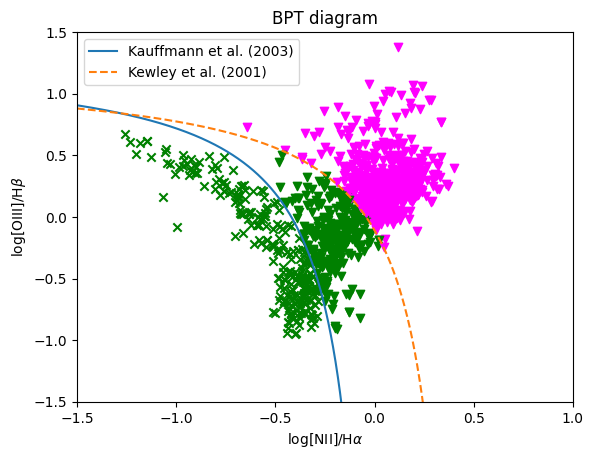

In [125]:
for x, y, colour, marker in zip(results['BPT_x'], results['BPT_y'], results['colour'], results['marker']):
    plt.scatter(x=x, y=y, c=colour, marker=marker)
plt.plot(x_kauffmann, y_kauffmann, 
         label="Kauffmann et al. (2003)")
plt.plot(x_kewley, y_kewley, 
         linestyle='--',
         label="Kewley et al. (2001)")
plt.xlabel(r"log[NII]/H$\alpha$")
plt.ylabel(r"log[OIII]/H$\beta$")
plt.xlim(-1.5, 1)
plt.ylim(-1.5, 1.5)
plt.title("BPT diagram")
plt.legend()

## Part - 2: Colour-colour diagram in mid IR

Another way of identifying a quasar is using colour-colour diagram as depicted by Wright et al. (2010):
<img src='qso-colour-colour.png'>

### Extinction correction

In [126]:
R_w1w2 = 0.056 ## source: https://arxiv.org/abs/2210.15918
R_w2w3 = -0.045

results['w1-w2'] = results['w1mpro'] - results['w2mpro'] - (R_w1w2 * results['e_bv_sfd'])
results['w2-w3'] = results['w2mpro'] - results['w3mpro'] - (R_w2w3 * results['e_bv_sfd'])
results['class_WISE'] = np.where((results['w1-w2'] >= 0.8), 'AGN', 
                                 (np.where((results['w2-w3'] <= 2), 'Spheroids', 
                                           (np.where(((results['w2-w3'] <= 3.5) & (results['w2-w3'] > 2)), 'Intermediate disks', 
                                                     (np.where((results['w2-w3'] > 3.5), 'SF disks', '')))))))
agn = results[results['class_WISE'] == 'AGN']

### Identifying AGNs

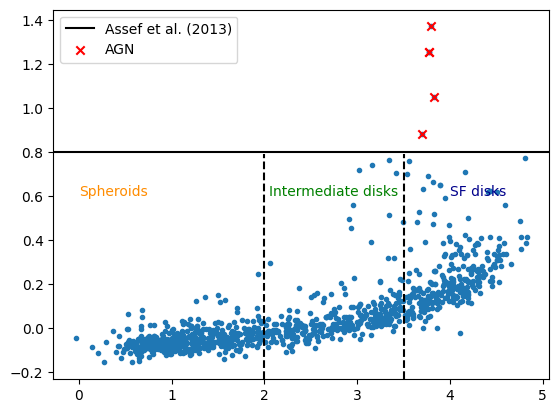

In [127]:
plt.scatter(results['w2-w3'], results['w1-w2'], marker='.')
plt.scatter(agn['w2-w3'], agn['w1-w2'], marker='x', c='red', label='AGN')
plt.axhline(y=0.8, c='k', label='Assef et al. (2013)')
plt.axvline(x=2, ymax=0.61, c='k', linestyle='--')
plt.axvline(x=3.5, ymax=0.61, c='k', linestyle='--')
plt.annotate('Spheroids', xy=(0,0.6), color='darkorange')
plt.annotate('Intermediate disks', xy=(2.05, 0.6), color='green')
plt.annotate('SF disks', xy=(4, 0.6), color='darkblue')
plt.legend()

The table below shows the details of the AGNs & ULGIRs in our data.

PS. First two entries are the same QSOs as seen by similar colours and colour excess.

In [128]:
agn

,plate,mjd,fiberid,z,subclass,e_bv_sfd,h_alpha_flux,h_beta_flux,oiii_5007_flux,nii_6584_flux,...,w3mpro,BPT_x,BPT_y,class_Kauffmann,class_Kewley,colour,marker,w1-w2,w2-w3,class_WISE
356,1665,52976,348,0.023091,b'AGN BROADLINE',0.160796,19829.88,4320.7400,24567.800,18681.270,...,5.124,-0.025914,0.754808,QSO,QSO,magenta,v,1.254995,3.771236,AGN
357,1666,52991,349,0.023135,b'AGN BROADLINE',0.160795,20177.67,4378.6000,25193.580,18784.210,...,5.124,-0.031078,0.759955,QSO,QSO,magenta,v,1.254995,3.771236,AGN
697,952,52409,247,0.009990,b'STARBURST',0.016660,14658.14,3131.9990,3576.736,6027.313,...,2.598,-0.385955,0.057665,QSO,SFG,green,v,1.370067,3.797750,AGN
798,2117,54115,351,0.007899,b'AGN',0.020713,2661.47,569.2051,4433.455,1745.936,...,5.255,-0.183093,0.891474,QSO,QSO,magenta,v,1.048840,3.826932,AGN
1025,1776,53858,632,0.021559,b'STARBURST',0.025653,16633.67,3754.2180,4133.134,6907.328,...,5.619,-0.381678,0.041760,QSO,SFG,green,v,0.880563,3.697154,AGN


The WISE colour-colour classification agrees with Kauffmann's classification and all of them are ULIRGs.